In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Чтение данных из файлов
file_1_path = '~/Downloads/file_1.xlsx'
file_2_path = '~/Downloads/file_2 (1).xlsx'
file_3_path = '~/Downloads/file_3.xlsx'

In [3]:
# Загрузка данных из file_1.xlsx (не агрегированные данные)
df_1 = pd.read_excel(file_1_path)

In [4]:
# Загрузка данных из file_2.xlsx (данные от разработчиков для сравнения)
df_2 = pd.read_excel(file_2_path)

In [5]:
# ----
# Шаг 1: Агрегация цен конкурентов по указанным правилам
# ----
# Функция агрегации цен конкурентов в зависимости от типа (avg, med, min, max, rnk)
def aggregate_prices(group):
    agg_type = group['agg'].iloc[0]
    if agg_type == 'avg':
        return group['comp_price'].mean()
    elif agg_type == 'med':
        return group['comp_price'].median()
    elif agg_type == 'min':
        return group['comp_price'].min()
    elif agg_type == 'max':
        return group['comp_price'].max()
    elif agg_type == 'rnk':
        ranked_group = group[group['rank'] != -1]
        if not ranked_group.empty:
            return ranked_group.loc[ranked_group['rank'].idxmin()]['comp_price']
        else:
            return None
    else:
        return None

In [6]:
# Применяем функцию агрегации для каждой группы товаров
df_1['comp_agg_price'] = df_1.groupby('sku').apply(aggregate_prices).reset_index(level=0, drop=True)

/var/folders/0g/5jw0hf3j6sv15s93hxpvgb9h0000gn/T/ipykernel_18280/95370349.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_1['comp_agg_price'] = df_1.groupby('sku').apply(aggregate_prices).reset_index(level=0, drop=True)


In [7]:
# ----
# Шаг 2: Расчет новой цены new_price с учетом отклонения на ±20%
# ----
def calculate_new_price(row):
    if pd.isna(row['comp_agg_price']):  # Если цен конкурентов нет
        return row['base_price']
    
    # Если разница между ценой конкурентов и текущей ценой <= 20%, принимаем цену конкурентов
    if abs(row['comp_agg_price'] - row['base_price']) / row['base_price'] <= 0.2:
        return row['comp_agg_price']
    else:
        return row['base_price']

In [8]:
# Применяем правило для расчета новой цены
df_1['new_price'] = df_1.apply(calculate_new_price, axis=1)

In [9]:
# ----
# Шаг 3: Сравнение результатов с данными разработчиков из file_2.xlsx
# ----
# Сравниваем рассчитанную цену с той, что предоставили разработчики
df_comparison = df_1[['sku', 'new_price']].merge(df_2[['sku', 'new_price']], on='sku', suffixes=('_my', '_dev'))
df_comparison['price_diff'] = df_comparison['new_price_my'] != df_comparison['new_price_dev']

In [10]:
# Проверка товаров, для которых есть расхождения
differences = df_comparison[df_comparison['price_diff']]

In [11]:
# Проверка отсутствующих товаров в результатах разработчиков
missing_in_dev = df_1[~df_1['sku'].isin(df_2['sku'])]

In [12]:
# ----
# Шаг 4: Визуализация данных из file_3.xlsx о процентах успешных оплат
# ----
# Загрузка данных file_3.xlsx
df_3 = pd.read_excel(file_3_path)

In [13]:
# Построение сводной таблицы для визуализации динамики оплат по месяцам и типам оплат
pivot_table = df_3.pivot_table(values='percents', index='time', columns='mode')

<Figure size 1000x600 with 0 Axes>

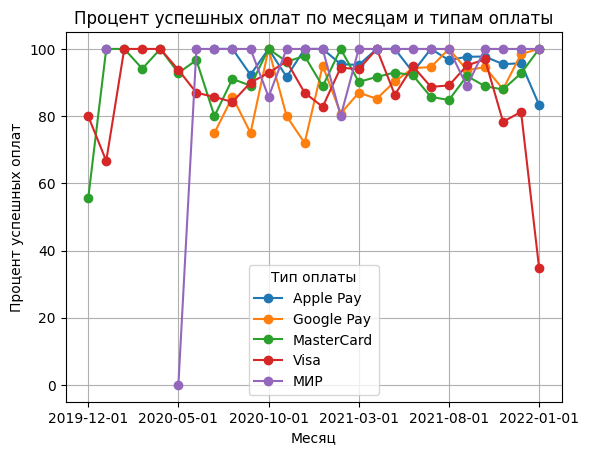

In [14]:
# Построение графика изменения успешных оплат по месяцам
plt.figure(figsize=(10, 6))
pivot_table.plot(kind='line', marker='o')
plt.title('Процент успешных оплат по месяцам и типам оплаты')
plt.xlabel('Месяц')
plt.ylabel('Процент успешных оплат')
plt.legend(title='Тип оплаты')
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

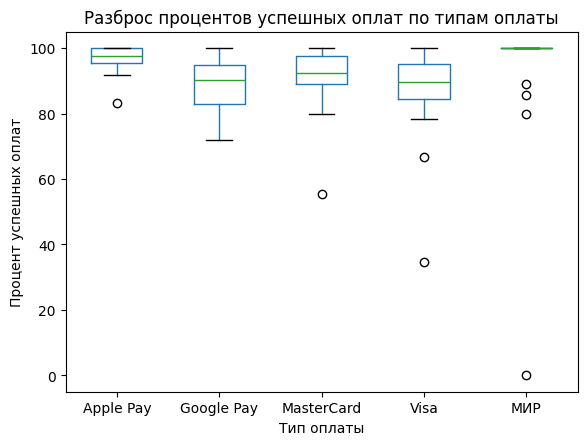

In [15]:
# Визуализация разброса успешных оплат по каждой системе оплаты с помощью boxplot
plt.figure(figsize=(8, 6))
df_3.boxplot(column='percents', by='mode', grid=False)
plt.title('Разброс процентов успешных оплат по типам оплаты')
plt.suptitle('')
plt.xlabel('Тип оплаты')
plt.ylabel('Процент успешных оплат')
plt.show()

In [16]:
# ----
# Шаг 5: Анализ стабильности систем оплаты на основе стандартного отклонения
# ----
# Рассчет стандартного отклонения для каждой системы оплаты (чем меньше, тем стабильнее)
stability = df_3.groupby('mode')['percents'].std().reset_index().sort_values(by='percents')

# Отображение стабильности
stability

,mode,percents
0,Apple Pay,4.288592
1,Google Pay,9.018085
2,MasterCard,9.105455
3,Visa,13.418051
4,МИР,21.565646


<Figure size 1000x600 with 0 Axes>

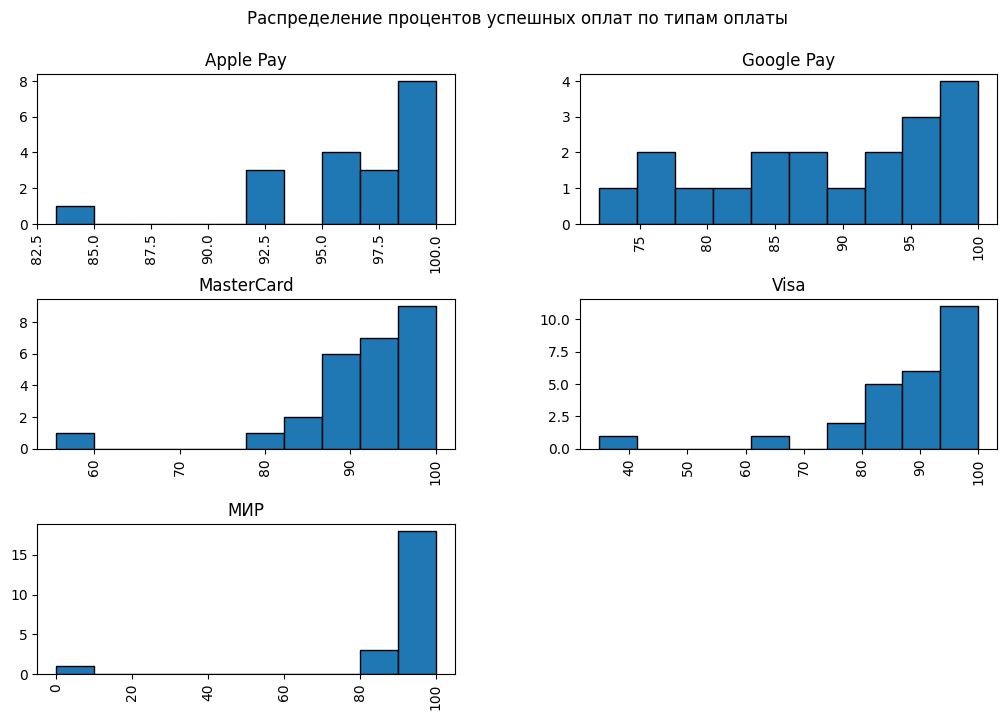

In [17]:
# ----
# Гистограмма распределения процентов успешных оплат по каждому типу оплаты
# ----
plt.figure(figsize=(10, 6))
df_3.hist(column='percents', by='mode', bins=10, layout=(3, 2), figsize=(12, 8), edgecolor='black')
plt.suptitle('Распределение процентов успешных оплат по типам оплаты')
plt.show()

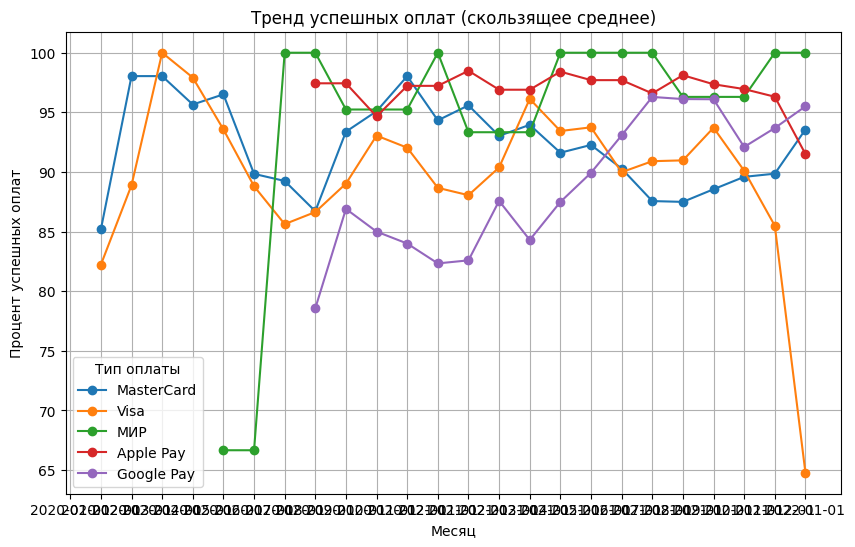

In [18]:
# ----
# Тренд успешных оплат с использованием скользящего среднего (moving average)
# ----
plt.figure(figsize=(10, 6))
for mode in df_3['mode'].unique():
    df_mode = df_3[df_3['mode'] == mode].copy()
    df_mode['percents_ma'] = df_mode['percents'].rolling(window=3).mean()  # Скользящее среднее по 3 точкам
    plt.plot(df_mode['time'], df_mode['percents_ma'], label=mode, marker='o')
plt.title('Тренд успешных оплат (скользящее среднее)')
plt.xlabel('Месяц')
plt.ylabel('Процент успешных оплат')
plt.legend(title='Тип оплаты')
plt.grid(True)
plt.show()

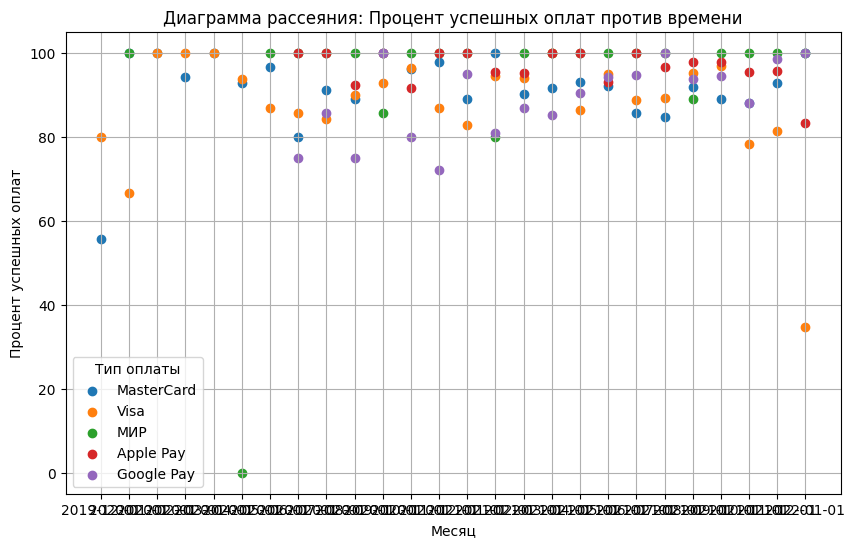

In [19]:
# ----
# Диаграмма рассеяния для каждого типа оплаты (процент успешных оплат против времени)
# ----
plt.figure(figsize=(10, 6))
for mode in df_3['mode'].unique():
    df_mode = df_3[df_3['mode'] == mode]
    plt.scatter(df_mode['time'], df_mode['percents'], label=mode)

plt.title('Диаграмма рассеяния: Процент успешных оплат против времени')
plt.xlabel('Месяц')
plt.ylabel('Процент успешных оплат')
plt.legend(title='Тип оплаты')
plt.grid(True)
plt.show()

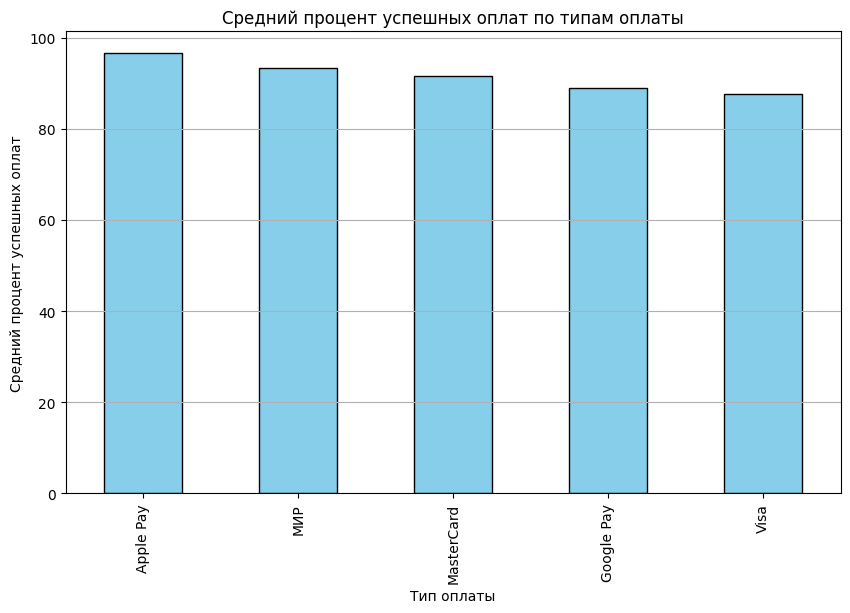

In [20]:
# ----
# Столбчатая диаграмма среднего процента успешных оплат по типам оплаты
# ----
plt.figure(figsize=(10, 6))
mean_percents = df_3.groupby('mode')['percents'].mean().sort_values(ascending=False)
mean_percents.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Средний процент успешных оплат по типам оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Средний процент успешных оплат')
plt.grid(axis='y')
plt.show()